# Credit Card Fraud Detection with AutoXGB

## Part 3 - Running AutoXGB
___
Reference: https://github.com/abhishekkrthakur/autoxgb

### Install AutoXGB

In [ ]:
# !pip install autoxgb

### Import dependencies and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from autoxgb import AutoXGB
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
pd.set_option('display.max_columns', None)

### Run AutoXGB Training and Prediction

In [2]:
%%time

# Define required parameters
train_filename = "data/processed/train.csv" # Path to training dataset
output = "output_autoxgb" # Name of output folder

# Set optional parameters
test_filename = "data/processed/test.csv"
task = "classification"
targets = ["TX_FRAUD"]
use_gpu = True
num_folds = 5
seed = 42
num_trials = 200
time_limit = 400
fast = False

# Start AutoXGB training
axgb = AutoXGB(
            train_filename=train_filename,
            output=output,
            test_filename=test_filename,
            task=task,
            targets=targets,
            use_gpu=use_gpu,
            num_folds=num_folds,
            seed=seed,
            num_trials=num_trials,
            time_limit=time_limit,
            fast=fast,
)

axgb.train()

2021-11-28 09:41:18.180 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: output
2021-11-28 09:41:18.186 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2021-11-28 09:41:18.389 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 2.28 Mb (77.3% reduction)
2021-11-28 09:41:18.397 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: binary_classification
2021-11-28 09:41:18.530 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.86 Mb (77.3% reduction)
2021-11-28 09:41:18.533 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
2021-11-28 09:41:18.562 | INFO     | autoxgb.autoxgb:_process_data:170 - Encoding target(s)
2021-11-28 09:41:18.571 | INFO     | autoxgb.autoxgb:_process_data:195 - Found 0 categorical features.
2021-11-28 09:41:18.821 | INFO     | autoxgb.autoxgb:_process_data:236 - Model config: train_filename='data/processed/train.csv' test_filename='data/proces

CPU times: user 9min 25s, sys: 4.23 s, total: 9min 29s
Wall time: 9min 27s


### Setup test dataset

In [3]:
# Import dataset and define target variable
test_df = pd.read_csv('data/processed/test.csv')
target = 'TX_FRAUD'

# Get y true labels
y_test = test_df[target]

### Get predictions on test set

In [4]:
# View probability predictions from AutoXGB
preds_proba = pd.read_csv('output/test_predictions.csv')
preds_proba.head()

,id,0,1
0,0,0.952505,0.047495
1,1,0.984080,0.015920
2,2,0.996838,0.003162
3,3,0.981726,0.018274
4,4,0.000083,0.999917


In [5]:
y_preds_proba = preds_proba.iloc[:,2]
y_preds_proba

0        0.047495
1        0.015920
2        0.003162
3        0.018274
4        0.999917
           ...   
67381    0.996280
67382    0.027509
67383    0.017280
67384    0.011525
67385    0.028157
Name: 1, Length: 67386, dtype: float64

In [6]:
# Set threshold (default = 0.5)
threshold = 0.5

# Generate predicted labels
preds = preds_proba.copy()
preds['label'] = preds['1'].apply(lambda x: 0 if x < threshold else 1)
preds = preds.iloc[: , 3:] # Drop unnecessary columns
preds.head()

,label
0,0
1,0
2,0
3,0
4,1


### Review performance metrics

In [7]:
# Define function to consolidate and display performance metrics
def gen_performance_metrics(y_true, y_preds, y_preds_proba, model_name, round_to=3):
    accuracy = round(metrics.accuracy_score(y_true, y_preds), round_to)
    f1_score = round(metrics.f1_score(y_true, y_preds), round_to)
    roc_auc = round(metrics.roc_auc_score(y_true, y_preds_proba), round_to)
    avg_precision = round(metrics.average_precision_score(y_true, y_preds_proba), round_to)

    df = pd.DataFrame([[model_name, accuracy, f1_score, roc_auc, avg_precision]], 
                        columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC Score', 'Average Precision'])
    
    display(df)
    display(metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_preds))

,Model,Accuracy,F1 Score,ROC AUC Score,Average Precision
0,AutoXGB,0.995,0.723,0.914,0.782


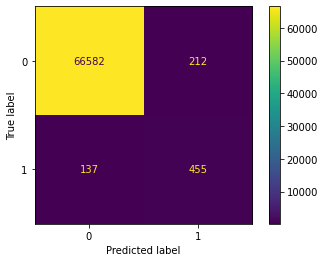

In [8]:
# Show performance assessment
gen_performance_metrics(y_test, preds, y_preds_proba, 'AutoXGB')